# Stacking Ensemble

**base learner：**
- GBR、lightGBM、XGBoost、RandomForest、ExtraRandomTrees、SVR

**meta learner：**
- XGBoost

**Introduce the six most important features：**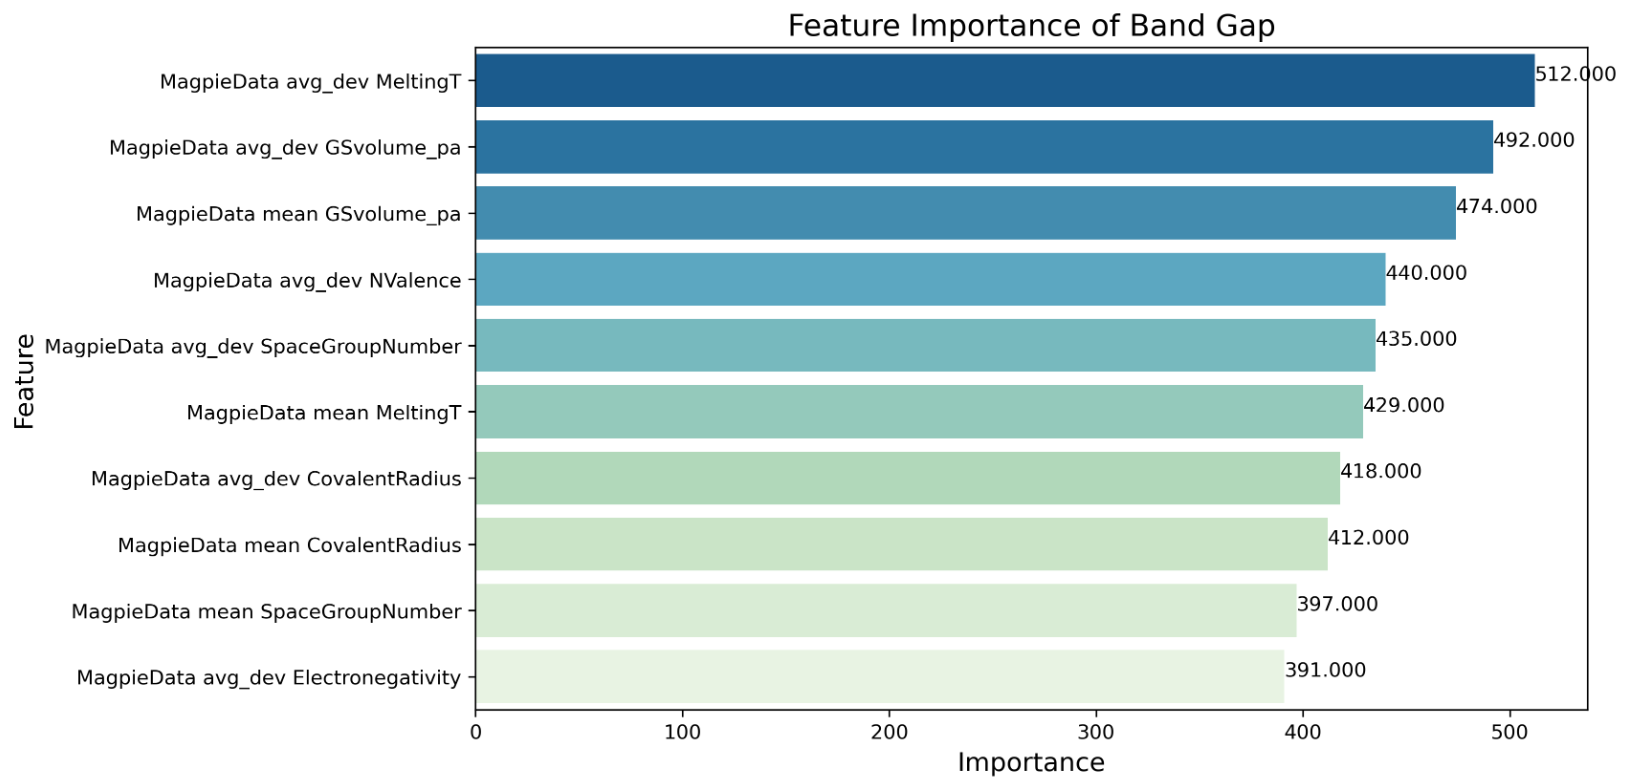

In [1]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [5]:
dft_train_X.shape, exp_train_X.shape, mixed_test_X.shape, mixed_test_y.shape

((7869, 117), (2510, 117), (1198, 117), (1198,))

## Base Learners Train

In [6]:
from sklearn.base import clone
# Import sklearn models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

In [7]:
# define dft_models with the best hyper parameters in the pervious step
dft_models = {
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=10, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    subsample=0.7, colsample_bytree=1.0,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),

    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=7, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),
    
    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

In [8]:
meta_train_X = pd.DataFrame()
meta_train_y = exp_train_y
dft_trained_models = {}
model_number = 0
model_nums = len(dft_models)

# train dft models and add the predictions to the exp train set
for model_name, model in dft_models.items():
    model_number += 1
    print(f"[{model_number}/{model_nums} - {model_name}] Training...")
    # train the model
    dft_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)
    y_pred = dft_model.predict(exp_train_X)
    meta_train_X[model_name] = y_pred
    # save the model
    dft_trained_models[model_name] = dft_model

[1/6 - GBR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.1min
Model training completed!
[2/6 - LightGBM] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23132
[LightGBM] [Info] Number of data points in the train set: 7869, number of used features: 117
[LightGBM] [Info] Start training from score 1.467977
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.4s
Model training completed!
[3/6 - XGBoost] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............. (step 2 of 2) Processing model, total=   5.6s
Model training completed!
[4/6 - RandomForest] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.3s
Model training completed!
[5/6 - ExtraRandomTrees] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.1s
Model training completed!
[6/6 - SVR] Training...
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  14.1s
Model training completed!


In [9]:
meta_train_X.head()

,GBR,LightGBM,XGBoost,RandomForest,ExtraRandomTrees,SVR
0,0.490254,0.547535,0.597906,0.588336,0.497758,0.197807
1,0.462400,0.687021,0.256546,0.652236,0.692217,1.643316
2,0.453328,0.617609,0.529493,0.543065,0.500161,0.338712
3,0.196765,0.240737,0.192950,0.274459,0.231471,0.200285
4,1.743351,1.804743,1.713918,1.724851,1.734360,1.567422


In [11]:
important_features_path = os.path.join(current_path, './metrics/feature_importance/exp')
important_features = pd.read_csv(os.path.join(important_features_path, 'exp_XGBoost_feature_importance.csv'))
important_features

,Feature,Importance
0,minimum LogThermalConductivity,0.035307
1,mean LogThermalConductivity,0.026694
2,mode LogThermalConductivity,0.026663
3,mean Density,0.026650
4,mean AtomicVolume,0.022665
5,mean BoilingT,0.018949
6,minimum MolarVolume,0.018237
7,range LogThermalConductivity,0.017369
8,maximum ThermalConductivity,0.016126
9,maximum Electronegativity,0.015815


In [13]:
# whether to use important features of exp as meta features
USE_IMPORTANT_FEAT = True
important_features = important_features['Feature'].values.tolist()


if USE_IMPORTANT_FEAT:
    important_features_train_df = exp_train_X[important_features].copy()
    meta_train_X = pd.concat([important_features_train_df, meta_train_X], axis=1)

    # add the important features to the test set
    meta_dft_test_X = dft_test_X[important_features].copy()
    meta_exp_test_X = exp_test_X[important_features].copy()
    meta_mix_test_X = mixed_test_X[important_features].copy()   
else:
    meta_dft_test_X = pd.DataFrame()
    meta_exp_test_X = pd.DataFrame()
    meta_mix_test_X = pd.DataFrame()


In [14]:
# add dft model predictions to the test set
for model_name, model in dft_trained_models.items():
    print(f"[{model_name}] Predicting...")
    # predict the test set
    y_pred = model.predict(dft_test_X)
    meta_dft_test_X[model_name] = y_pred
    # predict the mixed test set
    y_pred = model.predict(mixed_test_X)
    meta_mix_test_X[model_name] = y_pred
    # predict the exp test set
    y_pred = model.predict(exp_test_X)
    meta_exp_test_X[model_name] = y_pred

[GBR] Predicting...
[LightGBM] Predicting...
[XGBoost] Predicting...
[RandomForest] Predicting...


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[ExtraRandomTrees] Predicting...
[SVR] Predicting...


####################################################################################################
Training Stacking XGBoost on train data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.8s
Model training completed!
[Train_error] Evaluating Stacking XGBoost on train set:


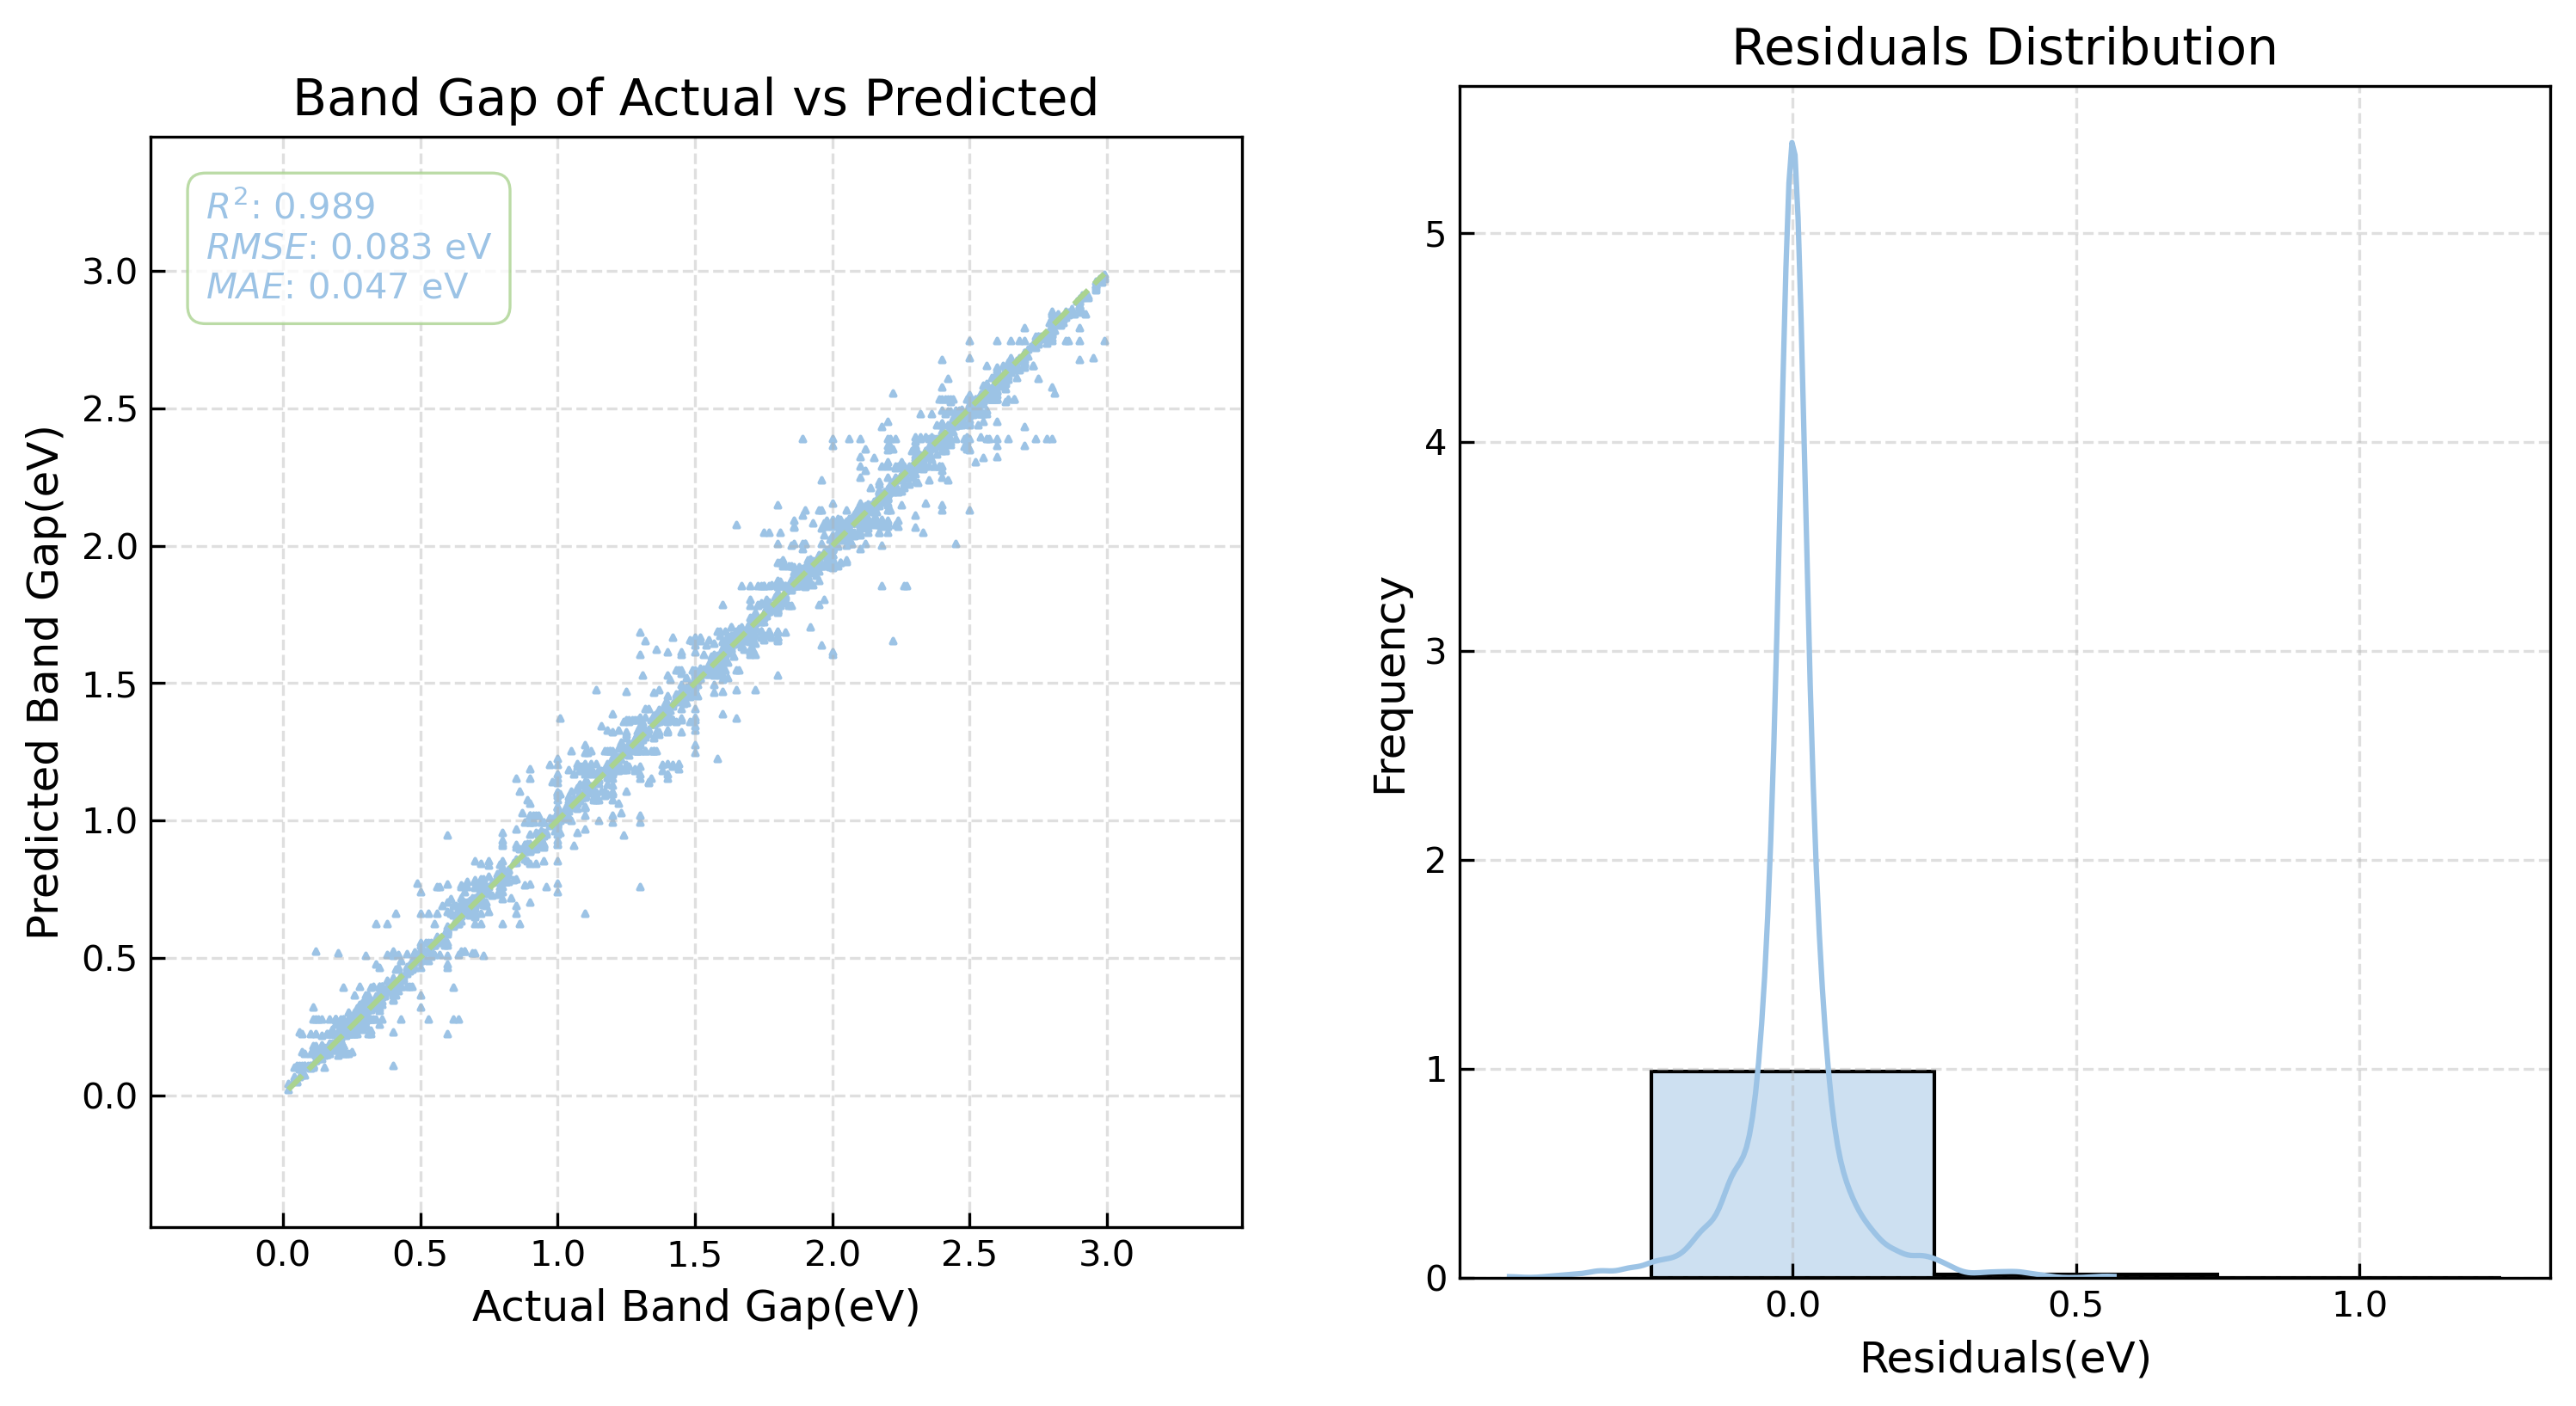


Model Evaluation Results:
Test set size: 2510
Test set: R²: 0.9893 RMSE: 0.0828 MAE: 0.0474 MAPE: 5.9161%
[Test Meta -> DFT] Evaluating Stacking XGBoost on DFT test set:


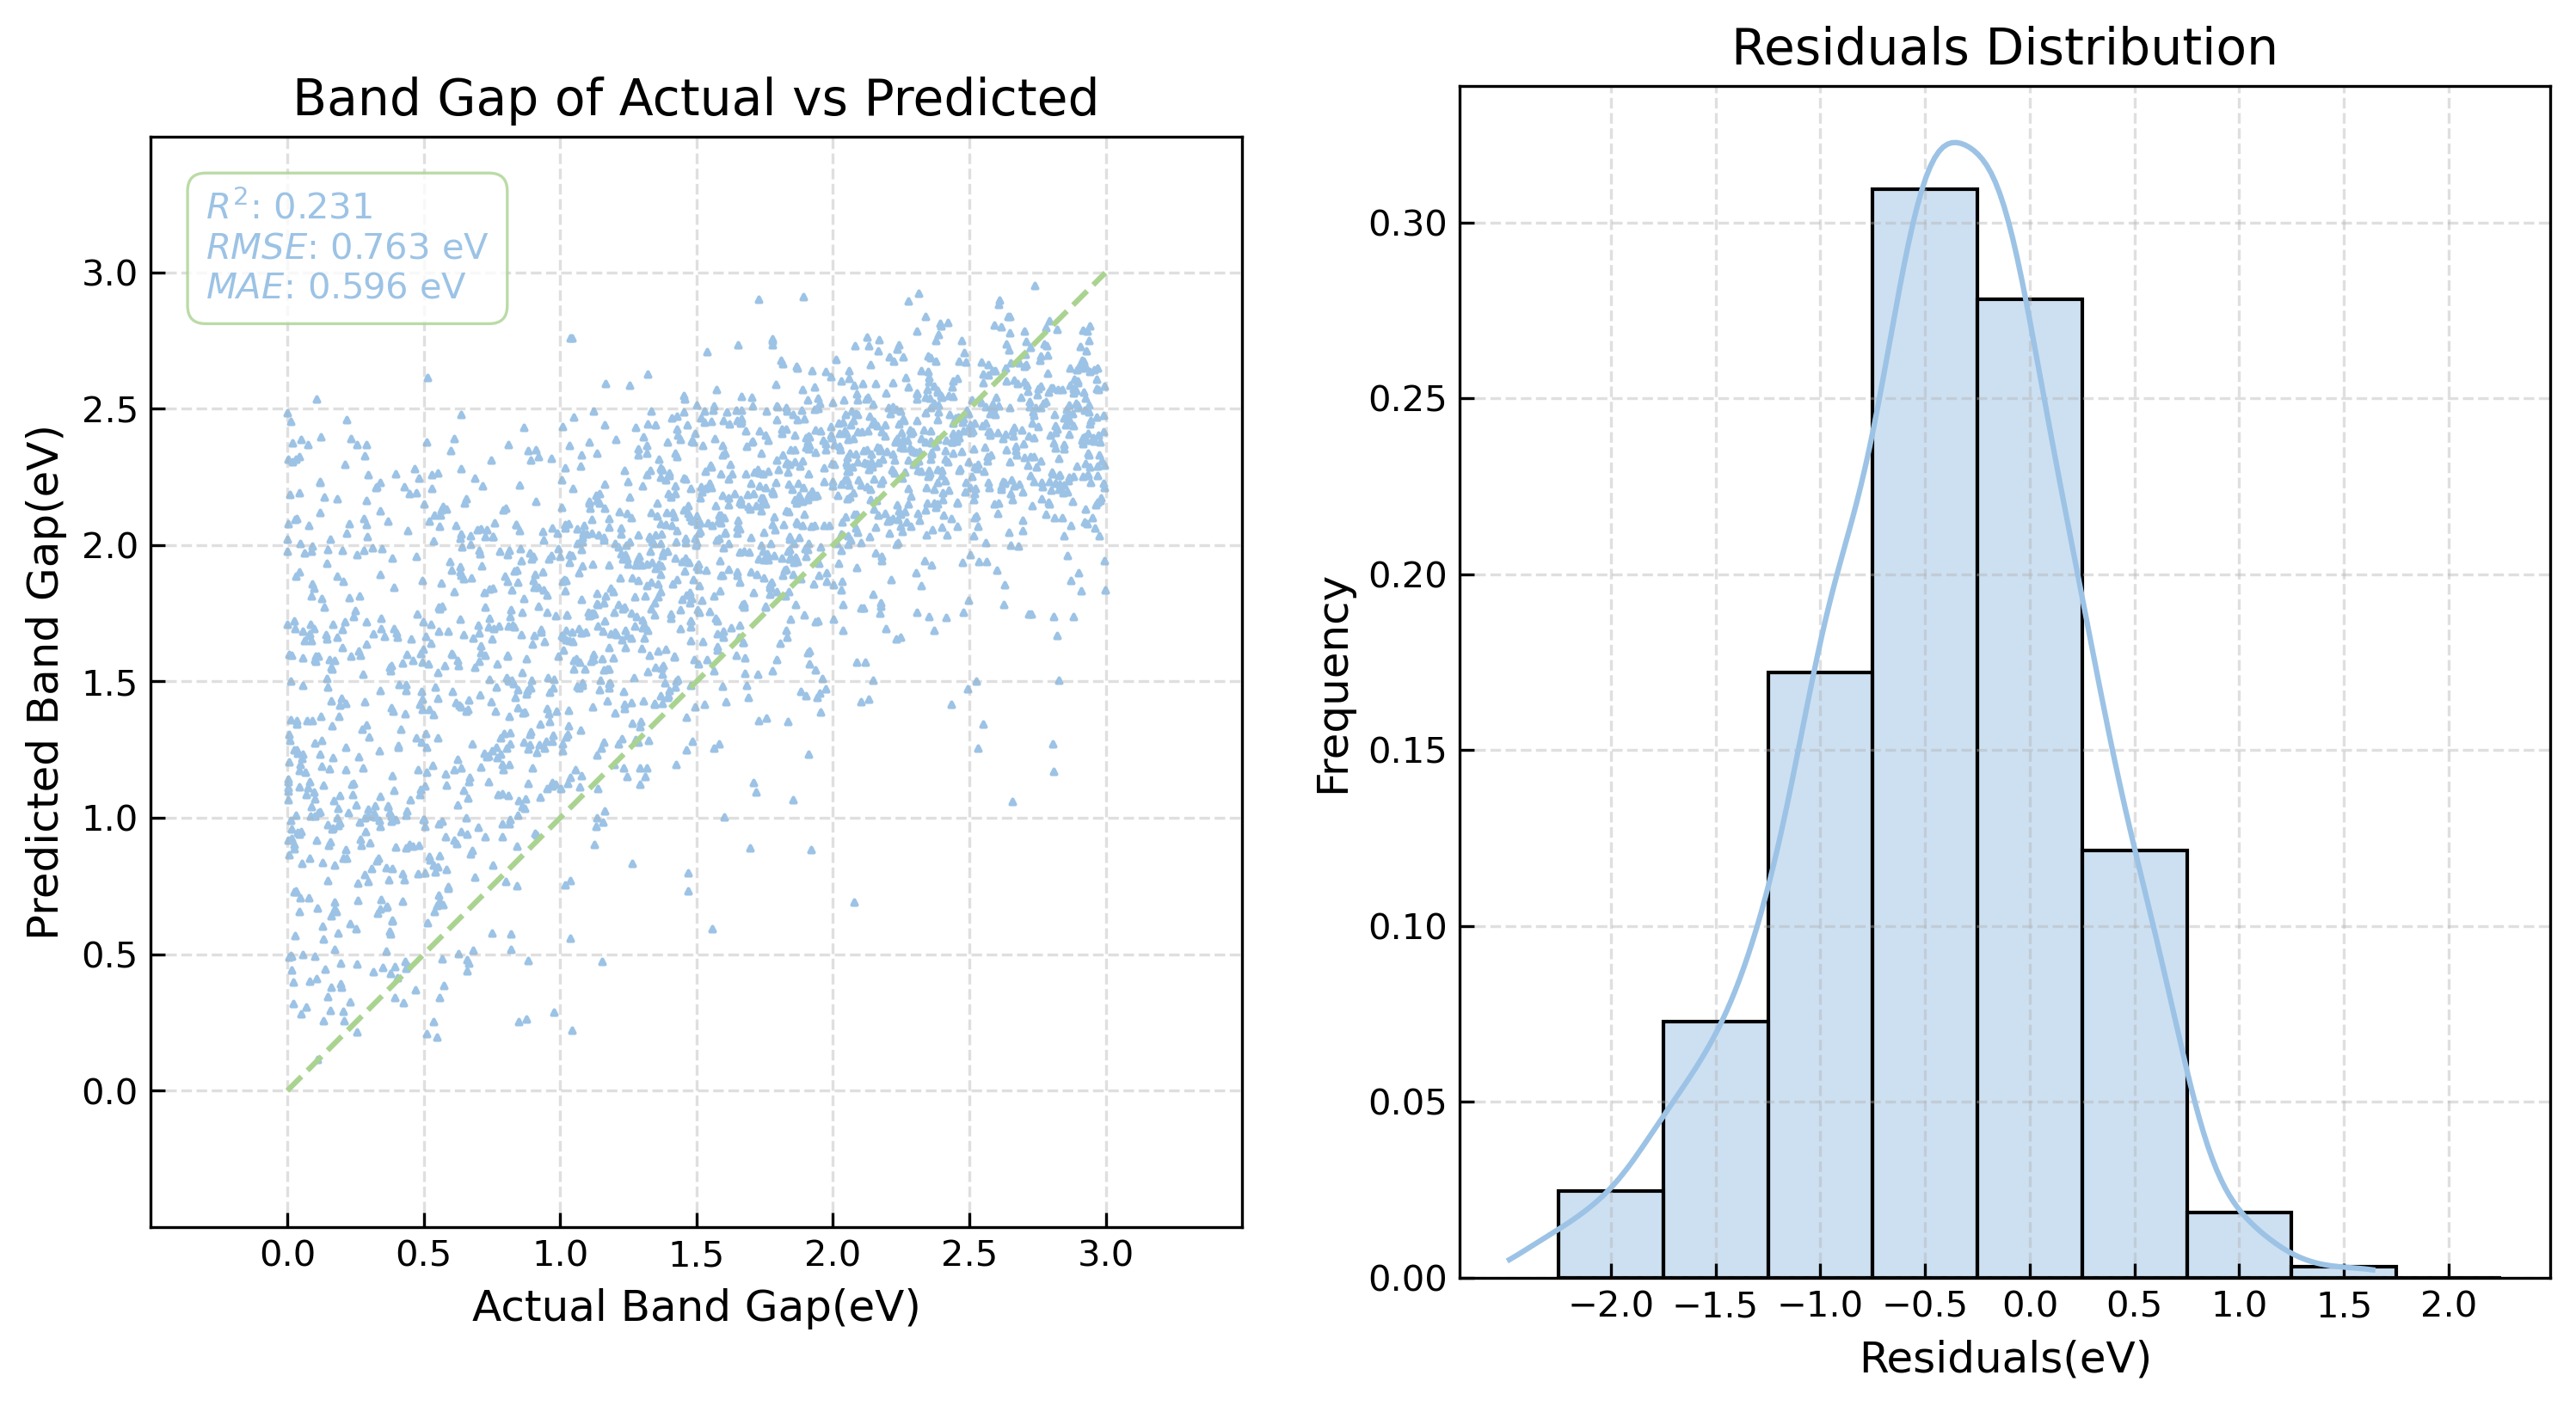


Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.2309 RMSE: 0.7625 MAE: 0.5961 MAPE: 2786.9123%
[Test Meta -> EXP] Evaluating Stacking XGBoost on EXP test set:


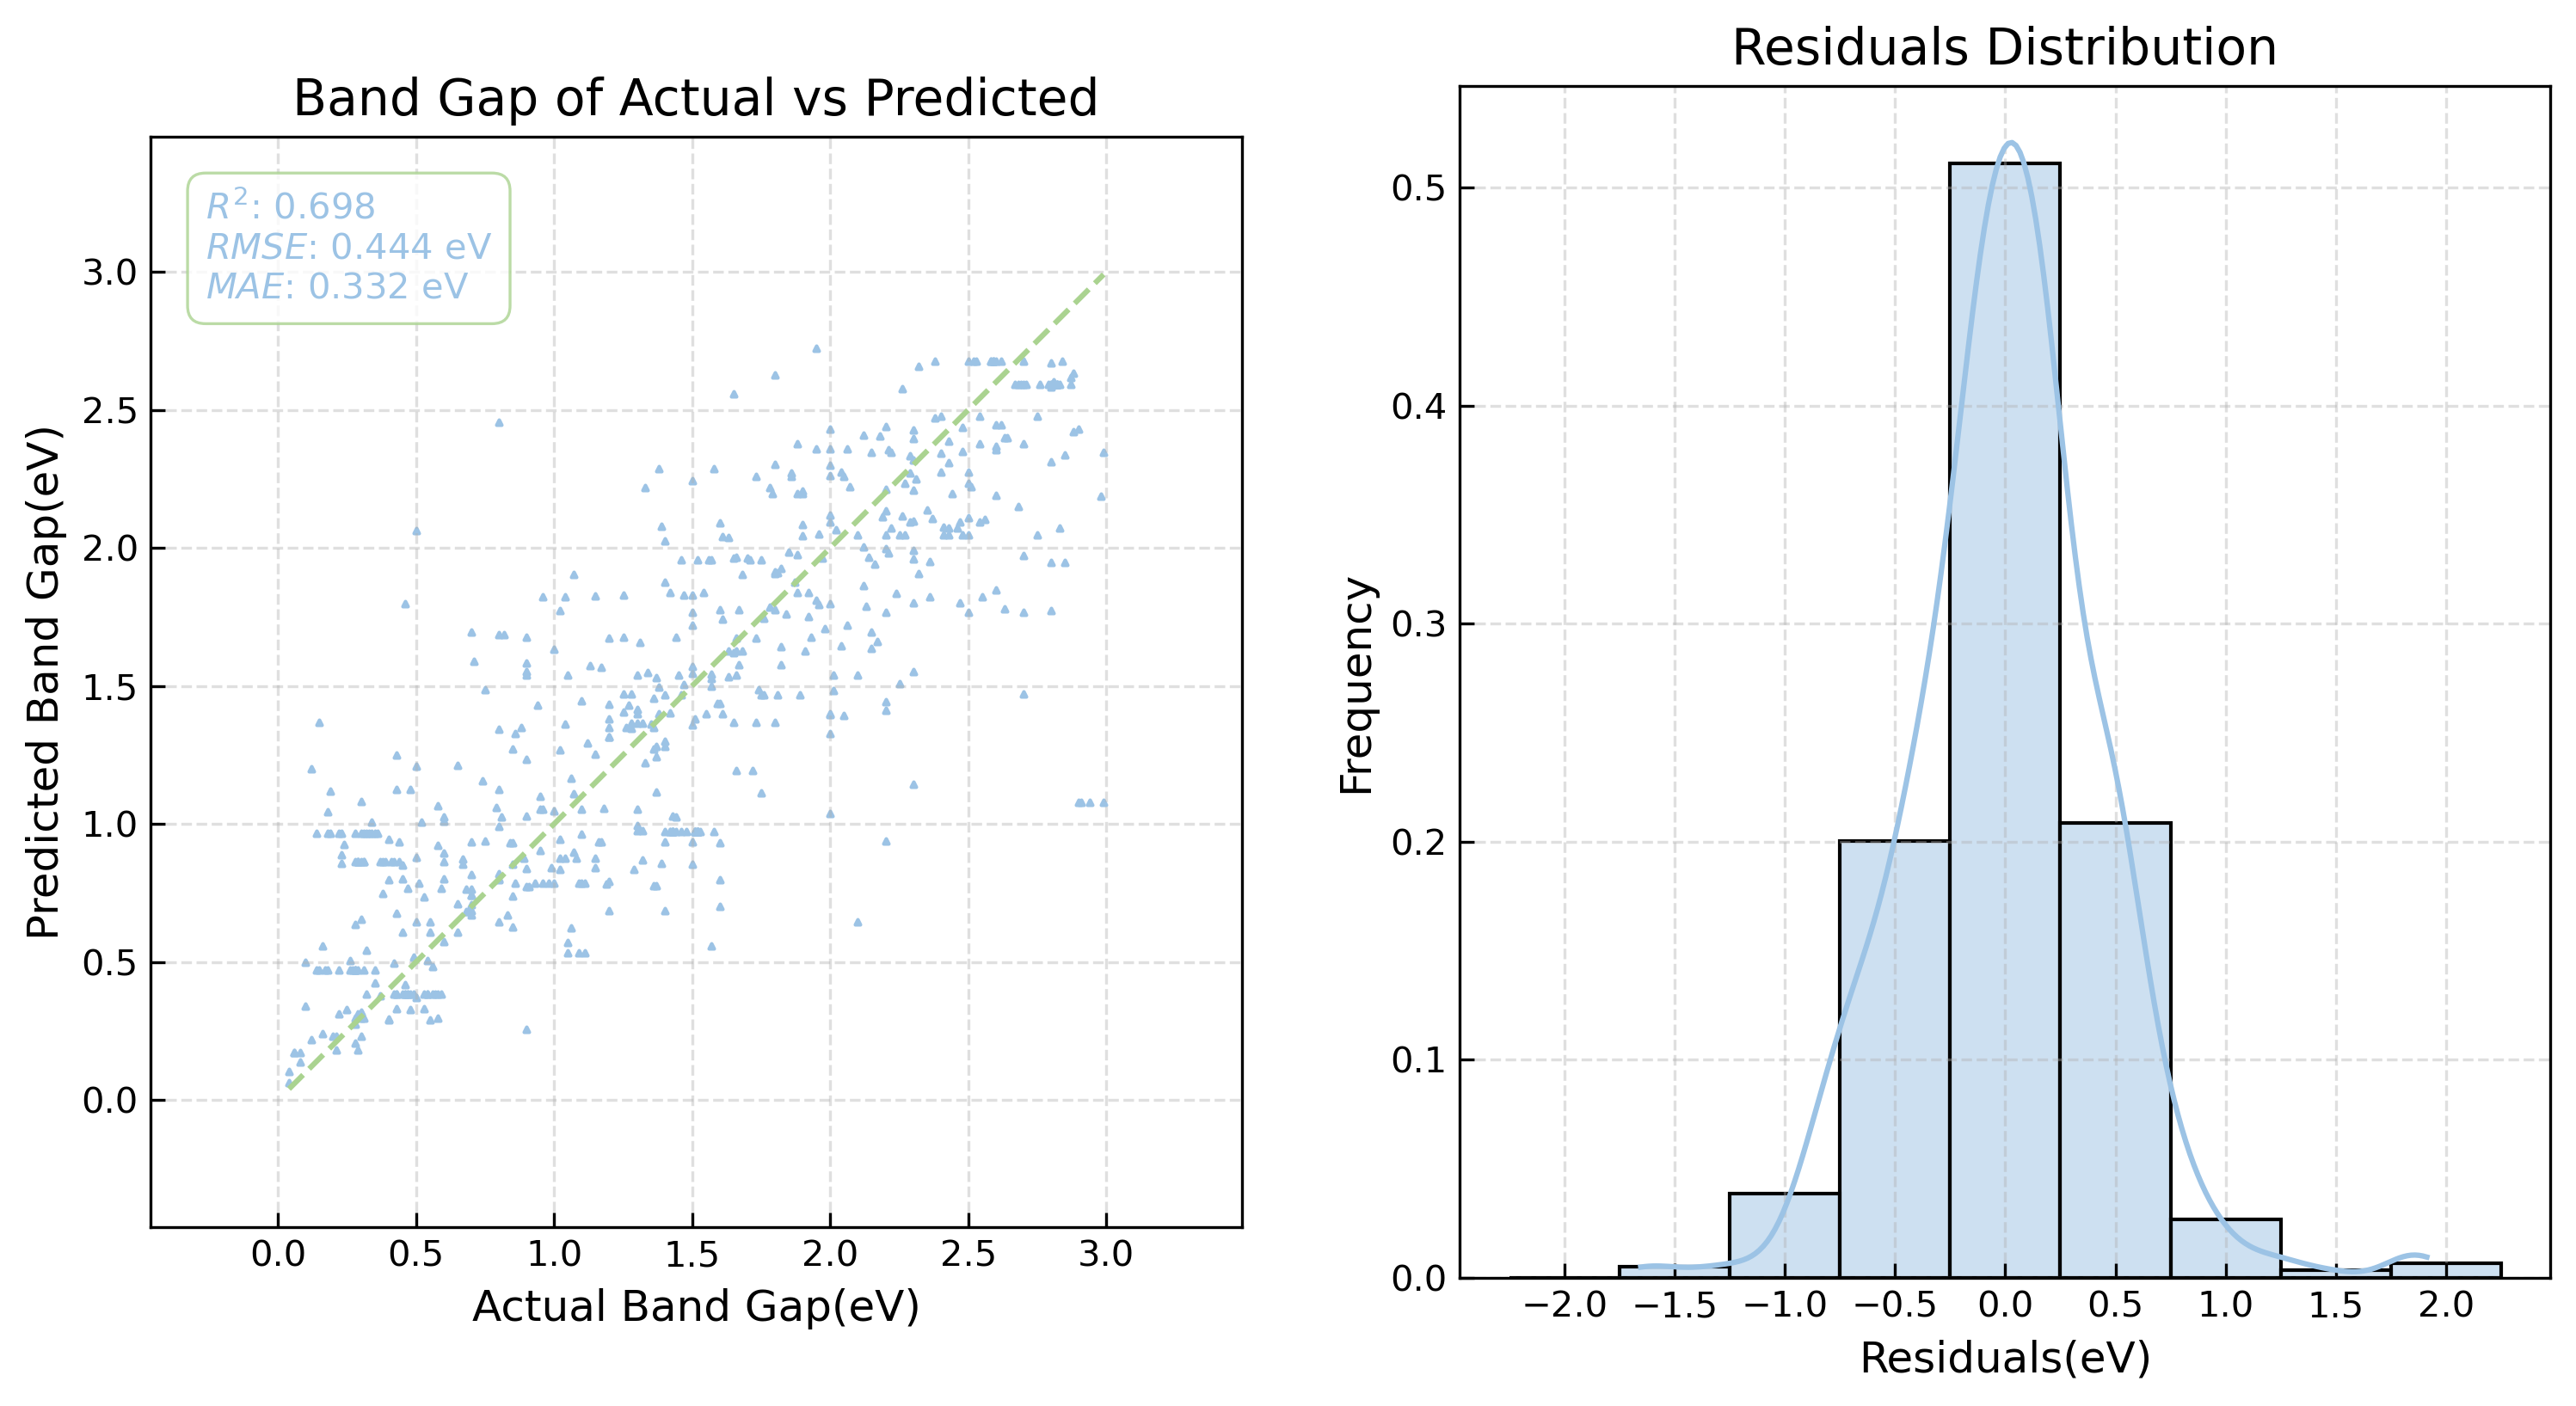


Model Evaluation Results:
Test set size: 599
Test set: R²: 0.6977 RMSE: 0.4438 MAE: 0.3319 MAPE: 44.9414%
[Test Meta -> MIX] Evaluating Stacking XGBoost on mixed test set:


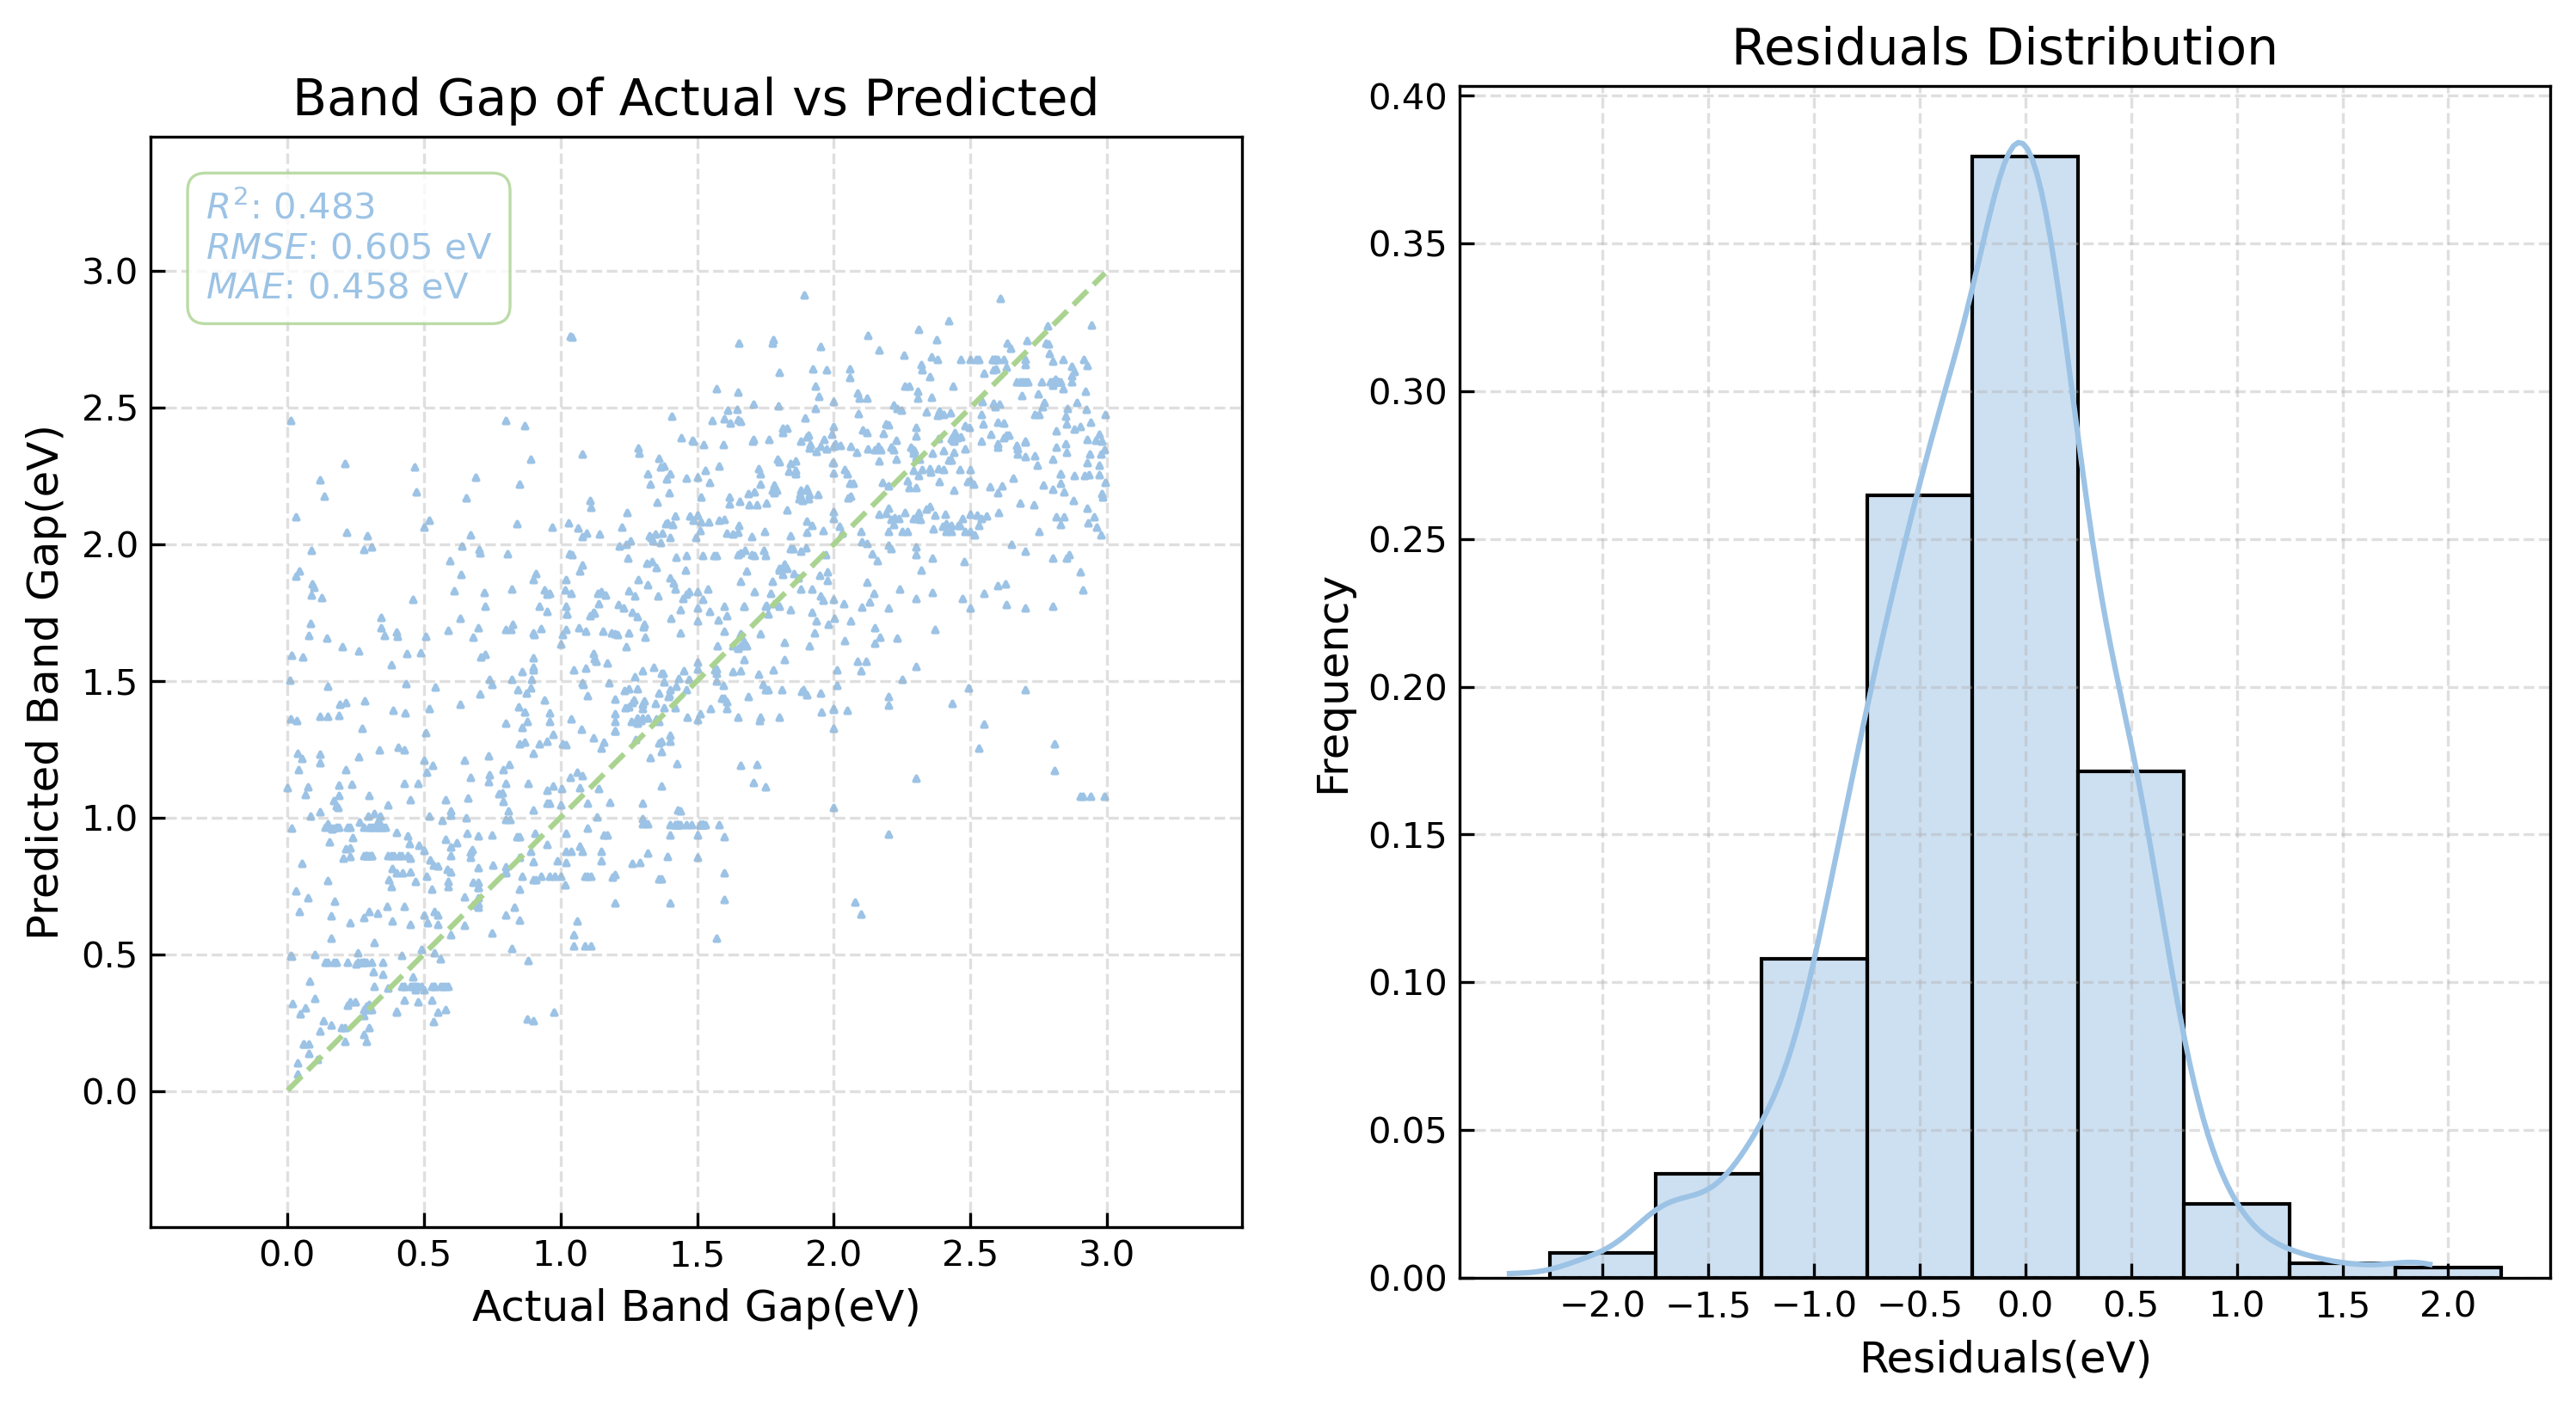


Model Evaluation Results:
Test set size: 1198
Test set: R²: 0.4827 RMSE: 0.6046 MAE: 0.4581 MAPE: 209.1134%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Stacking XGBoost,Train,meta,meta,0.989324,0.082832,0.047434
1,Stacking XGBoost,Test,meta,dft,0.230918,0.762545,0.596062
2,Stacking XGBoost,Test,meta,exp,0.697679,0.443795,0.331885
3,Stacking XGBoost,Test,meta,mix,0.482656,0.604596,0.458132


In [15]:
# meta model training
# 
MODEL_NAME = 'Stacking XGBoost'
# Train the model with the best hyperparameters on the entire training set
xgboost = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"Training {MODEL_NAME} on train data:")
print("-" * 100)

model = SingleModel(xgboost, random_state=RANDOM_SEED)
model.train(meta_train_X, meta_train_y)

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(meta_train_X, meta_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'meta',
'Test_set': 'meta',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test Meta -> DFT] Evaluating {MODEL_NAME} on DFT test set:")
metrics = model.evaluate(meta_dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test Meta -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(meta_exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test Meta -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(meta_mix_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'meta',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join('./metrics', 'stacking_metrics.csv'), index=False)
model_metrics